In [1]:
import numpy as np
import torch
import cv2

from glob import glob
from collections import OrderedDict
from matplotlib import pyplot as plt

from torch import nn
from torch.autograd import Function
from torch.autograd import gradcheck
from torch.optim import Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms

## 1. Загрузка данных

Если вам требуется работать с каким-нибубь набором данных (dataset), то прежде всего проверьте нет ли его среди встроенных наборов данных https://pytorch.org/vision/stable/datasets.html.

В текущем домашнем задании мы будем работать с набором данных FashionMNIST. Он присутствует в списке встроенных наборов данных, однако мы воспользуемся реализацией только для удобного и быстрого способа скачать наборы данных. Ниже предлагается реализовать собственный класс для считывания, обработки и упаковки данных.

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True
)

Воспользуемся функцией загрузки данных из репозитория наборов данных.

In [3]:
! ls data/FashionMNIST/raw

t10k-images-idx3-ubyte	   train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte	   train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [4]:
#https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

Для удобства PyTorch предоставляет ряд базовых классов `Dataset, DataLoader`, от которых предлагается отнаследоваться при разработке пользовательских классов. Базовый класс `Dataset` используется для загрузки и обработки данных, класс `DataLoader` используется для управления процессом загрузки данных, позволяет в многопоточном режиме загружать данные и упаковывать их.
Эти вспомогательные классы находятся в модуле `torch.utils.data`. 

При наследовании от класса `torch.utils.data.Dataset` требуется переопределить метод `__len__`, который возвращает количество примеров в наборе данных, а также метод `__getitem__`, который позволяет получить доступ к примеру из набора данных по индексу.

Реализуем класс для FasionMnist.

Элементами датасета должны являться пары '(np.array, int)', массив имеет размерность `(28, 28)`, тип элемента `np.float32`.

In [5]:
import os

class FashionMnist(Dataset):
    def __init__(self, path, train=True, image_transform=None, 
                 label_transform=None):
        if train:
            images, labels = load_mnist(os.path.join(path,"raw"))
        else:
            images, labels = load_mnist(os.path.join(path,"raw"), kind="t10k")

        ###########################################################
        ############# YOUR CODE HERE ##############################
        
        self.data = list(zip(images.reshape(-1, 28, 28), labels))
        
        ###########################################################

    def __len__(self,):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        return len(self.data)

    def __getitem__(self, idx):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        return self.data[idx]


In [6]:
test_dataset = FashionMnist("data/FashionMNIST", train=False)
train_dataset = FashionMnist("data/FashionMNIST")

Визуализируйте случайные элементы набора данных.

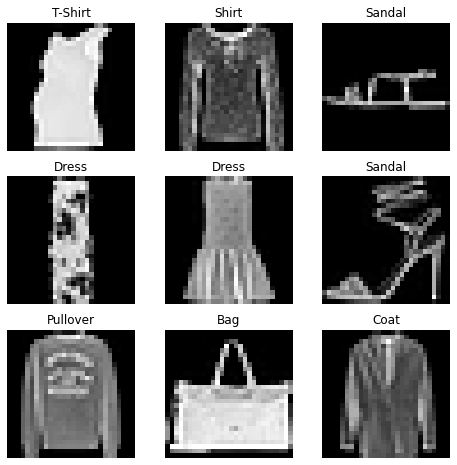

In [7]:
###########################################################
############# YOUR CODE HERE ##############################

# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()
###########################################################

В конструктор `Dataset` можно передать объект `torchvision.transforms`, который позволяет преобразовать исходные данные. Преобразование `torchvision.transforms.ToTensor` позволяет преобразоать данные из типа `PIL Image` и `numpy.float32` в тип `torch.float32`

Реализуйте собственную поддержку преобразований в `FashionMnist`. Проверьте, что приведение типов работает корректно. 

In [8]:
class ToTensor:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        return torch.from_numpy(sample)

In [9]:
transform = ToTensor()

test_dataset = FashionMnist("data/FashionMNIST", 
                            train=False, 
                            image_transform=transform, 
                            label_transform=transform
                            )
train_dataset = FashionMnist("data/FashionMNIST",
                             image_transform=transform, 
                             label_transform=transform
                             )

In [10]:
print(f"The type of the data is {type(test_dataset[0][0])}")

The type of the data is <class 'numpy.ndarray'>


Элементы набора данных могут быть объединены в пакеты (batch) явно и неявно. Если данные могут быть сконкатенированы или обЪединены каким-нибудь тривиальным способом, то можно не передавать никаких дополнительных парамертов в `torch.utils.data.Dataloader`.

In [11]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2, shuffle=True)
batch = next(iter(test_dataloader))

/home/pk/Программы/anaconda3/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py:149: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_numpy.cpp:178.)
  return default_collate([torch.as_tensor(b) for b in batch])
/home/pk/Программы/anaconda3/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py:149: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This t

In [12]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 28, 28])


Однако, если наша структура данных не позволяет нам использовать объединение по умолчанию, то можно написать собственную функцию, которая будет пакетировать данные. 

Реализуйте функцию, преобразующую последовательность элементов массива в пакет (batch).

In [13]:
def collate(batch):
    ###########################################################
    ############# YOUR CODE HERE ##############################
    imgs = torch.tensor([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch])
    ###########################################################
    return imgs, labels

Убедитесть, что все работает корректно. 

In [14]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2, 
                             shuffle=True, collate_fn=collate)
train_dataloader = DataLoader(train_dataset, batch_size=15, num_workers=2,
                              shuffle=True, collate_fn=collate)
batch = next(iter(test_dataloader))

/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


In [15]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 28, 28])


## 2. Реализация модулей нейронной сети (15 баллов)

В этом разделе мы полностью реализуем модули для полносвязанной сети. 

Для начала нам понадобится реализовать прямой и обратный проход через слои. 

Наши слои будут соответствовать следующему интерфейсу (на примере "тождественного" слоя):

Сначала, мы реализуем функцию и её градиент. 

In [16]:
class IdentityFunction(Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        return input

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        return grad_output

Разработанную функцию обернем классом `IdentityLayer`, все слои в `PyTorch` должны быть наследниками базового класса `nn.Module()`


In [17]:
class IdentityLayer(nn.Module):
    def __init__(self):
        # An identity layer does nothing
        super().__init__()
        self.identity = IdentityFunction.apply
    
    def forward(self, inp):
        # An identity layer just returns whatever it gets as input.
        return self.identity(inp)


### 2.1 Функция активации ReLU
Для начала реализуем функцию активации, слой нелинейности `ReLU(x) = max(x, 0)`. Параметров у слоя нет. Метод `forward` должен вернуть результат поэлементного применения `ReLU` к входному массиву, метод `backward` - градиент функции потерь по входу слоя. В нуле будем считать производную равной 0. Обратите внимание, что при обратном проходе могут понадобиться величины, посчитанные во время прямого прохода, поэтому их стоит сохранить в `ctx`.

In [18]:
class ReLUFunction(Function):
    @staticmethod
    def forward(ctx, input):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        mask = input > 0
        ctx.save_for_backward(mask)
        relu = input.clone()
        relu[~mask] = 0
        ###########################################################
        return relu

    @staticmethod
    def backward(ctx, grad_output):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        grad_input = grad_output.clone()
        mask, = ctx.saved_tensors
        grad_input[~mask] = 0
        ###########################################################
        return grad_input


In [19]:
class ReLU(nn.Module):
    def __init__(self):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        super().__init__()
        self.relu = ReLUFunction.apply
        ###########################################################
    
    def forward(self, input):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        return self.relu(input)

Не забываем после реализации функции проверить градиент, испльзуя функцию `gradcheck`.

In [20]:
###########################################################
############# YOUR CODE HERE ##############################

relu = ReLU()
x = torch.randn((5,10), requires_grad = True).double()

###########################################################
assert gradcheck(relu, x)

In [21]:
###########################################################
############# YOUR CODE HERE ##############################

torch_relu = nn.ReLU()
our_relu = ReLU()

###########################################################

assert torch.norm(torch_relu(x.float()) - our_relu(x)) < 1e-5

### 2.2 Линейный слой (linear, fully-connected)
Далее реализуем полносвязный слой без нелинейности. У слоя два набора параметров: матрица весов (weights) и вектор смещения (bias).

In [22]:
class LinearFunction(Function):
    @staticmethod
    def forward(ctx, inp, weight, bias):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        output = inp @ weight.T + bias
        ctx.save_for_backward(inp, weight, bias)
        ###########################################################
        return output
    @staticmethod
    def backward(ctx, grad_output):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        inp, weight, bias = ctx.saved_tensors
        grad_input = grad_output @ weight.data 
        grad_weight = grad_output.T @ inp.data
        grad_bias = grad_output.sum(dim = 0, keepdim = True)
        ###########################################################
        return grad_input, grad_weight, grad_bias

In [23]:
class Linear(nn.Module):
    def __init__(self, input_units, output_units):
        super().__init__()
        # initialize weights with small random numbers from normal distribution
        ###########################################################
        ############# YOUR CODE HERE ##############################
        self.weight = torch.nn.Parameter(
            torch.randn(output_units, input_units).double() * 1e-3
        )
        k = 1/input_units
        self.bias = torch.nn.Parameter(torch.rand(1, output_units).double()*(2*np.sqrt(k)) - np.sqrt(k))
        self.linear = LinearFunction.apply
        ###########################################################
        
    def forward(self,inp):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ###########################################################
        return self.linear(inp, self.weight, self.bias)

Проверим градиент, а также сравним с работой нашего модуля с имплементированным в `PyTorch`. 

Проверка градиента:

In [24]:
###########################################################
############# YOUR CODE HERE ##############################
linear = Linear(10,20)
x = torch.randn((5,10), requires_grad = True).double()

###########################################################
assert gradcheck(linear, x, eps = 1e-9)

Сравнение с `PyTorch`. 

In [25]:
###########################################################
############# YOUR CODE HERE ##############################
torch_linear = nn.Linear(10,20)
our_linear = Linear(10,20)
weight = torch.randn(20, 10) * 1e-3
k = 1/5
bias = torch.rand(1,20)*(2*np.sqrt(k)) - np.sqrt(k)
###########################################################

torch_state_dict = OrderedDict([("weight", weight), ("bias", bias.reshape(-1))])
our_state_dict = OrderedDict([("weight", weight), ("bias", bias)])
torch_linear.load_state_dict(torch_state_dict)
our_linear.load_state_dict(our_state_dict)

###########################################################
############# YOUR CODE HERE ##############################
assert torch.norm(torch_linear(x.float()) - our_linear(x)) < 1e-5
###########################################################

### 2.3 LogSoftmax (Log + Softmax)

Для решения задачи многоклассовой классификации обычно используют `softmax` в качестве нелинейности на последнем слое, чтобы получить "оценку" вероятности классов для каждого объекта:$$\hat y = softmax(x)  = \bigl \{\frac {exp(x_i)}{\sum_j exp(x_j)} \bigr \}_{i=1}^K, \quad K - \text{число классов}$$В этом случае удобно оптимизировать логарифм правдоподобия:$$L(y, \hat y) = -\sum_{i=1}^K y_i \log \hat y_i \rightarrow \min,$$где $y_i=1$, если объект принадлежит $i$-му классу, и 0 иначе. Записанная в таком виде, эта функция потерь совпадает с выражением для кросс-энтропии. Очевидно, что ее также можно переписать через индексацию, если через $y_i$ обозначить класс данного объекта:$$L(y, \hat y) = - \log \hat y_{y_i} \rightarrow \min$$В таком виде ее удобно реализовывать.

Реализуйте слой `LogSoftmax` (без параметров). Метод `forward` должен вычислять логарифм от `softmax`, а метод `backward` - пропускать градиенты. В общем случае в промежуточных вычислениях `backward` получится трехмерный тензор, однако для нашей конкретной функции потерь все вычисления можно реализовать в матричном виде. Поэтому мы будем предполагать, что аргумент `grad_output` - это матрица, у которой в каждой строке только одно ненулевое значение (не обязательно единица).

Комментарий: разобраться `Log-Sum-Exp trick`

In [26]:
class LogSoftmaxFunction(Function):
    @staticmethod
    def forward(ctx, inp):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        c = inp.max(dim = 1, keepdim = True).values
        ctx.save_for_backward(c, inp)
        logsumexp = (torch.log(torch.exp(inp - c).sum(dim = 1, keepdim = True)))
        return inp - c - logsumexp
        ###########################################################
    
    @staticmethod        
    def backward(ctx, grad_output):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        c, inp = ctx.saved_tensors
        
        # так как считаем, что в каждой строчке матрицы grad_output только одно ненудевое значение, 
        # то можно уменьшить размерность этой матрицы, просуммировав элементы по строчкам
        
        reduced_grad_output = torch.sum(grad_output, dim = 1, keepdim = True)
        softmax = torch.exp(inp - c) / torch.exp(inp - c).sum(dim = 1, keepdim = True)
        grad_input = grad_output - softmax * reduced_grad_output # раскрыли скобки в градиенте, умножив grad_output на единичную матрицу
        return grad_input
        ###########################################################

In [27]:
class LogSoftmax(nn.Module):
    def __init__(self):
        super().__init__()
        ###########################################################
        ############# YOUR CODE HERE ##############################
        self.logsoftmax = LogSoftmaxFunction.apply
        ###########################################################

    def forward(self, input):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        return self.logsoftmax(input)
        ###########################################################

Проверка градиентов.

In [28]:
logsoftmax = LogSoftmax()
x = torch.randn((5,10), requires_grad = True).double()

###########################################################
assert gradcheck(logsoftmax, x)

In [29]:
###########################################################
############# YOUR CODE HERE ##############################

torch_logsoftmax = nn.LogSoftmax(dim = 1)
our_logsoftmax = LogSoftmax()
x = torch.randn((5,10), requires_grad = True)
assert torch.norm(torch_logsoftmax(x.float()) - our_logsoftmax(x)) < 1e-5
###########################################################

### 2.4 Dropout
Реализуйте слой Dropout.

In [30]:
class DropoutFunction(Function):
    @staticmethod
    def forward(ctx, inp, p):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        distr = torch.ones(inp.size()) * (1 - p)
        samples = torch.bernoulli(distr)
        normalizing_const = torch.tensor((1 / (1 - p)), dtype = torch.double)
        out = inp * samples * normalizing_const
        ctx.save_for_backward(samples, normalizing_const)
        return out
        ###########################################################
        
    @staticmethod
    def backward(ctx, grad_output):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        samples, normalizing_const = ctx.saved_tensors
        grad_input = samples * normalizing_const * grad_output
    
        return grad_input, None
        ###########################################################

In [31]:
class Dropout(nn.Module):
    def __init__(self, p):
        super().__init__()
        ###########################################################
        ############# YOUR CODE HERE ##############################
        self.p = p
        self.dropout = DropoutFunction.apply
        ###########################################################
        
    def forward(self, input):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        if self.training:
            return self.dropout(input, self.p)
        else:
            return self.dropout(input, self.p) * (1 - self.p)
        ###########################################################

### 2.5 CrossEntropy

При решении задачи многоклассовой классификации мы будет использовать в качестве функции потерь кроссэнтропию. Реализуйте функцию потерь. В разделе 2.3 приведены полезные формулы.

In [32]:
class CrossEntropyFunction(Function):
    @staticmethod
    def forward(ctx, activations, target):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        ctx.save_for_backward(activations, target)
        # activations - результат применения logsoftmax, то есть матрица по строчкам которой логарифмы вероятностей принадлежности к классам 
        # выбираем логарифм вероятности для каждого объекта, соответствующий принадлежности к его истинному классу, 
        # а потом берём среднее с обратным знаком(так как это ошибка и мы её хотим минимизировать) по всем объектам
        return -activations[range(len(target)), target].mean()    
        ###########################################################

    @staticmethod
    def backward(ctx, grad_output):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        activations, target = ctx.saved_tensors
        grad = torch.zeros(activations.shape)
        grad[range(len(target)), target] = -1/activations.shape[0]
        grad_input = grad * grad_output
        return grad_input, None
        ###########################################################

class CrossEntropy(nn.Module):
    def __init__(self):
        super().__init__()
        ###########################################################
        ############# YOUR CODE HERE ##############################
        self.crossentropy = CrossEntropyFunction.apply
        ###########################################################

    def forward(self, activations, target):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        return self.crossentropy(activations, target)
        ###########################################################  

In [33]:
target = torch.randint(10, (5,), dtype=torch.int64)
our_crossentropy = CrossEntropy()
logsoftmax = LogSoftmax()
x = torch.randn((5,10), requires_grad = True)
logpredictions = logsoftmax(x)
# заметим, что nn.functional.cross_entropy(logpredictions, target) = nn.functional.cross_entropy(x, target)
assert torch.norm(nn.functional.cross_entropy(logpredictions, target) - our_crossentropy(logpredictions, target)) < 1e-5

Проверка градиентов.

In [34]:
###########################################################
############# YOUR CODE HERE ##############################
logsoftmax = LogSoftmax()
target = torch.randint(10, (5,), dtype=torch.int64)
crossentropy = CrossEntropy()
x = torch.randn((5,10), requires_grad = True).double()
logpredictions = logsoftmax(x)
assert gradcheck(crossentropy, (logpredictions, target))
###########################################################

## 3. Сборка и обучение нейронной сети (5 балла)

Реализуйте произвольную нейросеть, состоящую из ваших блоков. Она должна состоять из нескольких полносвязанных слоев.

In [35]:
class Block(nn.Module):
    def __init__(self, input_size, output_size, relu=True, dropout=True, p = 0.5):
        super().__init__()
        
        self.linear = Linear(input_size, output_size)
        self.relu = ReLU() if relu else nn.Identity()
        self.dropout = Dropout(p) if dropout else nn.Identity()

    def forward(self, x):
        y1 = self.linear(x)
        y2 = self.relu(y1)
        y3 = self.dropout(y2)
        return y3

In [36]:
class Network(nn.Module):
    def __init__(self, input_size=28*28, hidden_layers_size=32, num_layers=5,
                 num_classes=10):
        super().__init__()
        ###########################################################
        ############# YOUR CODE HERE ##############################
    
        layers = [nn.Flatten(), Block(input_size, hidden_layers_size, relu = True, dropout = False)]
        
        for _ in range(num_layers):
            layers.append(Block(hidden_layers_size, hidden_layers_size, relu = True, dropout = True))
            
        layers.append(Block(hidden_layers_size, num_classes, relu = False, dropout = False))
        
        layers.append(LogSoftmax())
        
        self.net = nn.Sequential(*layers)
        
       
        ###########################################################

    def forward(self, inp):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        return self.net(inp.double())
        ###########################################################
    def predict(self, inp):
        ###########################################################
        ############# YOUR CODE HERE ##############################
        res = self.net(inp.double())
        return res.argmax(dim = 1)
        ###########################################################


Ниже приведены функции, реализующие обучение нейронной сети. В данном задании их предлагается просто переиспользовать. 

In [37]:
class EmptyContext:
    def __enter__(self):
        pass
    
    def __exit__(self, *args):
        pass

In [38]:
# accuract metric for our classififcation
def accuracy(model_labels, labels):
    return torch.mean((model_labels == labels).float())

In [39]:
def perform_epoch(model, loader, criterion, 
                optimizer=None, device=None):
    is_train = optimizer is not None
    model = model.to(device)
    if is_train:  
        model.train()
    else:
        model.eval()

    total_loss = 0
    total_acc = 0
    total_n = 0
    with EmptyContext() if is_train else torch.no_grad():
        for batch_data, batch_labels in loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device) 
            model_labels = model(batch_data)
            model_prediction = model.predict(batch_data)
            batch_labels = batch_labels.to(torch.int64)
            new_loss = criterion(model_labels, batch_labels)
            if is_train:
                optimizer.zero_grad()
                new_loss.backward()
                optimizer.step() 

            one_batch_loss = float(criterion(model_labels, batch_labels))
            one_batch_acc = accuracy(model_prediction, batch_labels)
            
            total_loss += one_batch_loss
            total_acc += one_batch_acc
            total_n += 1 
    return (total_loss / total_n, total_acc / total_n) 

Теперь обучим нашу нейронную сеть. В данном разделе будем использовать оптимизатор `Adam` с параметрами по умолчанию.

In [40]:
model     = Network()
optimizer = torch.optim.Adam(model.parameters())
criterion = CrossEntropy()

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

for epoch in range(10):
    loss, acc = perform_epoch(model, train_dataloader, criterion, 
                                optimizer=optimizer, device=device)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 0 : loss 1.4559177421756282, accuracy 0.3891849219799042
Current learning rate: 0.001


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 1 : loss 1.199940356858684, accuracy 0.4895666539669037
Current learning rate: 0.001


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 2 : loss 1.1322998690060364, accuracy 0.5173488259315491
Current learning rate: 0.001


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 3 : loss 1.1533510198879584, accuracy 0.5161823630332947
Current learning rate: 0.001


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 4 : loss 1.155807482731561, accuracy 0.52036452293396
Current learning rate: 0.001


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 5 : loss 1.2081366980989559, accuracy 0.4903692603111267
Current learning rate: 0.001


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 6 : loss 1.2009869271250408, accuracy 0.4892999827861786
Current learning rate: 0.001


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 7 : loss 1.1745739404553381, accuracy 0.5145983099937439
Current learning rate: 0.001


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 8 : loss 1.218427773506033, accuracy 0.5102660655975342
Current learning rate: 0.001


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 9 : loss 1.1860476864790281, accuracy 0.5105156302452087
Current learning rate: 0.001


In [44]:
print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch - 9 : loss 1.1860476864790281, accuracy 0.5105156302452087
Current learning rate: 0.001


Дальше:
- Проведите эксперименты с числом слоев. 
- Постройте графики зависимости качества модели на тренировочной и тестовой выборках от числа слоев. Для получения статистически значимых результатов повторите эксперименты несколько раз.
- Сделайте выводы. 

In [46]:
from tqdm import tqdm

In [51]:
number_of_layers = [1,2,3,4,5]
number_of_epoches = [3,5,10] 
Mean_Accuracy_Train = []
Mean_Accuracy_Test = []
for i in tqdm(number_of_layers):
    Accuracy_Train = []
    Accuracy_Test = []
    for epoches in number_of_epoches:
        
        model     = Network(num_layers = i)
        optimizer = torch.optim.Adam(model.parameters())
        criterion = CrossEntropy()


        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        model.to(device)

        for epoch in range(epoches):
            loss_train, acc_train = perform_epoch(model, train_dataloader, criterion, 
                                optimizer=optimizer, device=device)
            print(f"Epoch - {epoch} : loss train {loss_train}, accuracy train {acc_train}")
            
        Accuracy_Train.append(acc_train)
        
        loss_test, acc_test = perform_epoch(model, test_dataloader, criterion, 
                            optimizer=None, device=device)
        print("loss test ", loss_test, "accuracy test ", acc_test)
        Accuracy_Test.append(acc_test)
    
    Mean_Accuracy_Train.append(np.mean(Accuracy_Train))
    Mean_Accuracy_Test.append(np.mean(Accuracy_Test))

  0%|                                                     | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 0 : loss train 0.8830415997189179, accuracy train 0.6573231220245361


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 1 : loss train 0.7060119628116155, accuracy train 0.7480982542037964


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 2 : loss train 0.6721723445998279, accuracy train 0.7635999321937561


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


loss test  0.7558019667083894 accuracy test  tensor(0.7291)


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 0 : loss train 1.00335831895505, accuracy train 0.6052021384239197


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 1 : loss train 0.7887186809643015, accuracy train 0.7156121134757996


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 2 : loss train 0.7526170360107716, accuracy train 0.7341979742050171


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 3 : loss train 0.7303140173087299, accuracy train 0.7423983812332153


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 4 : loss train 0.730499476555879, accuracy train 0.7466489672660828


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


loss test  0.8091796806132837 accuracy test  tensor(0.7216)


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 0 : loss train 0.8472824878306938, accuracy train 0.6696920990943909


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 1 : loss train 0.6981168753628789, accuracy train 0.7431157231330872


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 2 : loss train 0.675741168942026, accuracy train 0.7595992684364319


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 3 : loss train 0.6631882047965059, accuracy train 0.76741623878479


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 4 : loss train 0.6375503720933531, accuracy train 0.7780348658561707


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 5 : loss train 0.6252288166311035, accuracy train 0.7822680473327637


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 6 : loss train 0.6196152749144278, accuracy train 0.7845660448074341


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 7 : loss train 0.6020412982993462, accuracy train 0.7979678511619568


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 8 : loss train 0.6013274708718818, accuracy train 0.7964011430740356


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 9 : loss train 0.5987352954252994, accuracy train 0.7967840433120728


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
 20%|████████▊                                   | 1/5 [04:06<16:27, 246.81s/it]

loss test  0.6691758955848379 accuracy test  tensor(0.7827)


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 0 : loss train 1.1378217244109121, accuracy train 0.5185452699661255


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 1 : loss train 0.9346579057571236, accuracy train 0.6104685664176941


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 2 : loss train 0.9102981209885905, accuracy train 0.6266032457351685


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


loss test  1.2425857050627633 accuracy test  tensor(0.4902)


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 0 : loss train 1.3801090380854044, accuracy train 0.42796626687049866


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 1 : loss train 1.0961744026432523, accuracy train 0.5305808782577515


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 2 : loss train 1.061402166984586, accuracy train 0.5434309840202332


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 3 : loss train 1.0239919080249322, accuracy train 0.5599806904792786


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 4 : loss train 1.022826481515917, accuracy train 0.5651648640632629


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


loss test  1.3368951120999641 accuracy test  tensor(0.4270)


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 0 : loss train 1.2081003036418958, accuracy train 0.49639594554901123


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 1 : loss train 0.9801318044116518, accuracy train 0.6128356456756592


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 2 : loss train 0.9379491077640448, accuracy train 0.6421876549720764


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 3 : loss train 0.9213201800991837, accuracy train 0.6498891711235046


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 4 : loss train 0.9009210278379324, accuracy train 0.6575567126274109


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 5 : loss train 0.903756261679017, accuracy train 0.6644905209541321


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 6 : loss train 0.9015644624600552, accuracy train 0.6658404469490051


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 7 : loss train 0.884336340743345, accuracy train 0.6761084198951721


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 8 : loss train 0.8639504683080902, accuracy train 0.686259388923645


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 9 : loss train 0.8577321657583139, accuracy train 0.6861262917518616


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
 40%|█████████████████▌                          | 2/5 [08:56<13:36, 272.02s/it]

loss test  1.1911551470846349 accuracy test  tensor(0.5135)


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 0 : loss train 1.3651542204754192, accuracy train 0.43678268790245056


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 1 : loss train 1.0862606268313562, accuracy train 0.5496472716331482


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 2 : loss train 1.0423419650898638, accuracy train 0.5710151791572571


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


loss test  1.6084282586812106 accuracy test  tensor(0.3506)


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 0 : loss train 1.4931254135690735, accuracy train 0.3672538101673126


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 1 : loss train 1.2576059913952744, accuracy train 0.44038692116737366


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 2 : loss train 1.2298312198218135, accuracy train 0.4466703534126282


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 3 : loss train 1.226520319595855, accuracy train 0.4524030387401581


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 4 : loss train 1.2158578817914814, accuracy train 0.4546363651752472


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


loss test  1.633260749251859 accuracy test  tensor(0.3195)


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 0 : loss train 1.3601910729577735, accuracy train 0.4353152811527252


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 1 : loss train 1.0901284278446977, accuracy train 0.5590991973876953


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 2 : loss train 1.0460655036535342, accuracy train 0.5786985754966736


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 3 : loss train 1.0157890669316814, accuracy train 0.5887171626091003


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 4 : loss train 1.0390801824999032, accuracy train 0.572950005531311


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 5 : loss train 0.9752396115584494, accuracy train 0.5984342694282532


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 6 : loss train 0.980266774825705, accuracy train 0.6030002236366272


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 7 : loss train 1.0432921152733594, accuracy train 0.5798848867416382


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 8 : loss train 1.0215232374482899, accuracy train 0.5897835493087769


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 9 : loss train 0.9842573138832547, accuracy train 0.5939662456512451


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
 60%|██████████████████████████▍                 | 3/5 [14:26<09:56, 298.37s/it]

loss test  1.4772207575038543 accuracy test  tensor(0.3861)


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 0 : loss train 1.7243132572371547, accuracy train 0.29066991806030273


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 1 : loss train 1.5640723139130048, accuracy train 0.3380714952945709


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 2 : loss train 1.5037935017559816, accuracy train 0.3612719476222992


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


loss test  2.1663690521786965 accuracy test  tensor(0.1297)


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 0 : loss train 1.855886957638954, accuracy train 0.254902184009552


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 1 : loss train 1.5445883439306742, accuracy train 0.35788798332214355


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 2 : loss train 1.3838176790401684, accuracy train 0.41365522146224976


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 3 : loss train 1.3502221683663402, accuracy train 0.43613773584365845


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 4 : loss train 1.321945876808143, accuracy train 0.4405714273452759


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


loss test  2.0923077954956364 accuracy test  tensor(0.2317)


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 0 : loss train 1.414605745467091, accuracy train 0.40645042061805725


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 1 : loss train 1.1191082476770708, accuracy train 0.5244979858398438


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 2 : loss train 1.0838777609796524, accuracy train 0.5520812273025513


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 3 : loss train 1.0577681847616105, accuracy train 0.5727322101593018


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 4 : loss train 1.0571410439055855, accuracy train 0.5748661160469055


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 5 : loss train 1.0774542224774168, accuracy train 0.5674648284912109


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 6 : loss train 1.0399154698845976, accuracy train 0.5827658772468567


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 7 : loss train 1.0611646552185, accuracy train 0.586764931678772


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 8 : loss train 1.0391128123634008, accuracy train 0.5997841954231262


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 9 : loss train 1.0661725965459898, accuracy train 0.5824999213218689


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
 80%|███████████████████████████████████▏        | 4/5 [20:43<05:29, 329.57s/it]

loss test  1.8019744798759771 accuracy test  tensor(0.2642)


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 0 : loss train 1.478959737065554, accuracy train 0.38988471031188965


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 1 : loss train 1.1812798249823806, accuracy train 0.5037994980812073


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 2 : loss train 1.1436661665320136, accuracy train 0.5222644209861755


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


loss test  2.1080618033087384 accuracy test  tensor(0.1790)


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 0 : loss train 1.4617242310281018, accuracy train 0.378185510635376


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 1 : loss train 1.2028664049708262, accuracy train 0.4861501455307007


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 2 : loss train 1.1557467159314105, accuracy train 0.5046659111976624


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 3 : loss train 1.1280264042712553, accuracy train 0.5156986117362976


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 4 : loss train 1.0930534012367856, accuracy train 0.5356314778327942


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


loss test  2.0824296810336382 accuracy test  tensor(0.1944)


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 0 : loss train 1.7976489698926075, accuracy train 0.2569683790206909


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 1 : loss train 1.541177702386588, accuracy train 0.3091873526573181


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 2 : loss train 1.503489997123665, accuracy train 0.3288709819316864


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 3 : loss train 1.466773264597826, accuracy train 0.33720487356185913


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 4 : loss train 1.4658486377899247, accuracy train 0.3406214714050293


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 5 : loss train 1.4887534259852777, accuracy train 0.3414050042629242


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 6 : loss train 1.4345933358585983, accuracy train 0.3486883044242859


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 7 : loss train 1.4064961730333045, accuracy train 0.3614054024219513


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 8 : loss train 1.447687445777718, accuracy train 0.3572882413864136


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])


Epoch - 9 : loss train 1.541171431258324, accuracy train 0.3426711857318878


/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
/tmp/ipykernel_72641/73920298.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_new.cpp:204.)
  imgs = torch.tensor([item[0] for item in batch])
100%|████████████████████████████████████████████| 5/5 [27:36<00:00, 331.38s/it]

loss test  2.2592379338322037 accuracy test  tensor(0.1593)


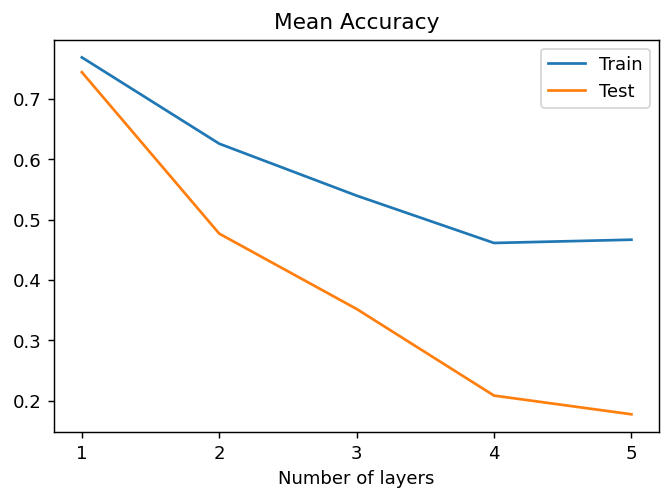

In [53]:
plt.figure(figsize = (6, 4), dpi = 130)
plt.plot(number_of_layers, Mean_Accuracy_Train, label='Train')
plt.plot(number_of_layers, Mean_Accuracy_Test, label='Test')
plt.xticks([1,2,3,4,5])
plt.xlabel("Number of layers")
plt.title("Mean Accuracy")
plt.legend()
plt.show()

Согласно графикам можно сделать следующие выводы:
    Во-первых, с увеличением числа слоёв модель становися более сложной, поэтому ей требуется больше эпох для обучения. Во-вторых, среди выбранного диапазона количества слоёв лучшее качество показала модель с наименьшим числом слоёв из рассматривыемых. Возможно, более сложные модели(с большим числом слоёв) недообучились, либо для решения конкретной задачи больше подходят более простые модели, либо мы не дошли до оптимального числа слоёв в силу небольшого диапазона.

## 4. Бонусная часть.

### 4.1 Реализация метода оптимизации (3 + 3 балла).
Реализуйте сами метод оптимизации  для рассмотренной выше архитектуры. Вы можете выбрать произвольный метод от градиентного спуска до современных вариантов. Продемонстрируйте правильную работу метода оптимизации, сравните его работы с Adam. 

**Дополнительные баллы** вы получите, если метод будет уникален среди сдавших задание. 

In [ ]:
class SotaOptimizer(Optimizer):
    def __init__(self, params, lr=1e-3):
        defaults = dict(lr=lr)
        super(SotaOptimizer, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SotaOptimizer, self).__setstate__(state)

    @torch.no_grad()
    def step(self,):

        for group in self.param_groups:
            lr = group['lr']
            for p in group['params']:
                if p.grad is not None:
                    p.data.add_(-lr*p.grad)

### 4.2 Реализация современной функции активации (2 + 2 балла).
Реализуйте одну из активаций, предложенных на лекции или в статье. Например, `Hardswish`. Сравните сеть с вашей активацией и с `ReLU`. 

**Дополнительные баллы** вы получите, если функция будет уникальна среди сдавших задание. 